# The mathematically perfect cappuccino
Getting the perfect foam cap on your home-made cappuccino can be a difficult task for any coffee-lover. Both the height of the foam cap and the rate of decay are difficult to predict ahead of time. Using multilevel modelling we can estimate your coffee's foam height.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate
import pints

## Background: foam formation in milky coffees
Water does not normally form a stable foam, as bubbles rapidly coalesce in order to minimise the surface area - and so the surface tension - of the water. Foam on milk is formed because proteins in milk act as a surfactant which lowers the surface tension of the liquid. This surfactant effect slows the coalescence of bubbles which would normally happen, and so allows bubbles to form which coalesce relatively slowly. In a cup of milky coffee, these bubbles form a foam cap on top of the coffee, which slowly decays in volume as bubbles within the foam coalesce (see https://doi.org/10.1111/j.1471-0307.2010.00629.x).

A reasonable initial model for the height of the foam in the coffee cup seems to be an ordinary differential equation (equation 1). This model assumes that the decay of foam height over time, $\frac{d h}{d t}$, reduces proportionally to the height of the foam, $h$. This seems reasonable as the number of bubbles should be proportional to the volume (and so height) of the foam.

\begin{equation}
\frac{d h}{d t} = -k \cdot h
\tag{1}
\end{equation}

Using this model, the predicted foam height is shown below for an initial foam height of 1cm and a decay rate of 1.

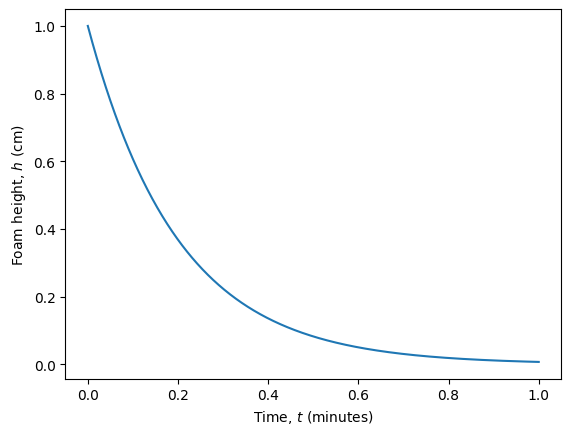

In [2]:
class ExampleModel(pints.ForwardModel):
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        y0 = parameters[0]
        def r(y, t, p):
            dydt = -p[0] * y
            return dydt
        return integrate.odeint(r, y0, times, (parameters[1:],)).reshape(times.shape)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = ExampleModel()

times = times = np.linspace(0, 1, 1000)
values = model.simulate([1, 5], times)

# Plot the results
plt.figure()
plt.xlabel('Time, $t$ (minutes)')
plt.ylabel('Foam height, $h$ (cm)')
plt.plot(times, values, label='Foam height')
plt.show()

In this model, two variables dictate the behaviour of the foam: the rate of decay, $k$, and the initial foam height, $h_0$. Ordinarily it is difficult to predict either of these values before we have foamed the milk for our coffee. Because of this, we do not know ahead of time whether our coffee will be the perfect cappuccino or a damp, foamless squib. However, if we know certain initial conditions, such as milk type and age, then it may be possible to predict foam behaviour, and so to know whether our coffee foam will be good, bad, or perfect. 

## Maximum Likelihood Estimation
For a single cup of coffee we can measure the height of the foam at time $t$. We can use this to estimate the parameters $k$ and $h_0$ but each measurement is not perfect - there will be some error between the observed height and its actual value.

_Maximum Likelihood Estimation_ uses a likelihood, defined by the modeller, to estimate the set of parameters most likely to have produced a given, measured set of data. It does this by comparing output from a proposed model to noisy data from the real system: the proposed model that gives the closest output to measured data is said to have the ‘maximum likelihood’. Using Maximum Likelihood Estimation and our observed measurements, we can pinpoint the most likely value of parameters $k$ and $h_0$.

For example, the following example simulates a coffee by adding random noise to the "true" foam height. It then estimates the most likely parameter values from these simulated measurements.

Minimising error measure
Using Seperable Natural Evolution Strategy (SNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      29.61619   0:00.0
1     12     21.24818   0:00.0
2     18     1.21932    0:00.0
3     24     1.21932    0:00.0
20    126    0.467      0:00.0
40    246    0.429      0:00.1
60    366    0.429      0:00.1
80    486    0.429      0:00.1
100   606    0.429      0:00.2
120   726    0.429      0:00.2
140   846    0.429      0:00.2
160   966    0.429      0:00.3
180   1086   0.429      0:00.3
200   1206   0.429      0:00.3
220   1326   0.429      0:00.4
240   1446   0.429      0:00.4
260   1566   0.429      0:00.4
280   1686   0.429      0:00.5
298   1788   0.429      0:00.5
Halting: No significant change for 200 iterations.
Score at true solution:
0.43044170993175274
Found solution:          True parameters:
 9.95071298026874440e-01     1.00000000000000000e+00
 4.95896848995418438e+00     5.00000000000000000e+00


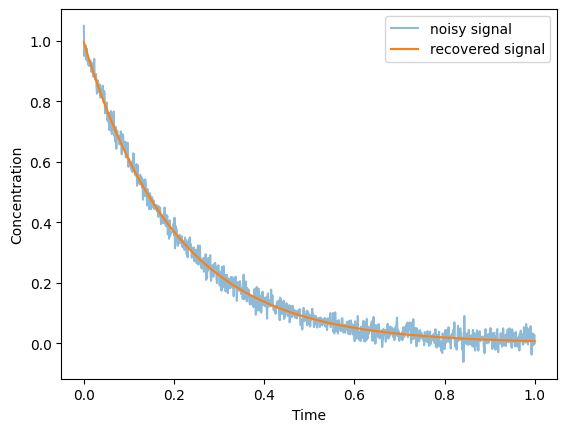

In [3]:
# Define the 'true' parameters
true_parameters = [1, 5]

# Run a simulation to get test data
values = model.simulate(true_parameters, times)

# Add some noise
values += np.random.normal(0, 0.02, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0.1, 0.1], [10, 10])

# Select a starting point
x0 = [1, 1]

# Perform an optimization using SNES (see docs linked above). 
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries, method=pints.SNES)
print('Score at true solution:')
print(score(true_parameters))
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values, alpha=0.5, label='noisy signal')
plt.plot(times, problem.evaluate(found_parameters), label='recovered signal')
plt.legend()
plt.show()

## Sampling with MCMC
We now know the most likely parameters for our coffee foam, but we don't know how much confidence to put in these estimates as we don't know the spread of likely values they might take (the posterior probability distribution). _Sampling_ repeatedly guesses parameters at random from a probability distribution. The type useful here is Markov chain Monte Carlo (MCMC), which repeatedly takes parameter guesses and accepts or rejects each guess based on the probability of those parameters being correct, compared to the previous guess. This ensures that we are sampling from the posterior distribution. When repeated over many samples (typically in the order of thousands; the approximation typically improves as the number of samples increases), this builds a large set of accepted parameter sets. By viewing a histogram of accepted samples we can take an approximation of the ‘true’ parameter value (according to the model used). There are a number of algorithms for parameter proposal and acceptance; the most common and widely-known is the Metropolis-Hastings algorithm.

In [13]:
log_likelihood = pints.GaussianLogLikelihood(problem) # We assume gaussian noise with an unknown standard deviation
x0 = [
    [1, 1, 1],
    [2, 2, 2],
    [3, 3, 3]
]
mcmc = pints.MCMCController(log_likelihood, 3, x0, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(20000)
mcmc.set_log_to_screen(True)
samples = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0.5        0:00.0
2     9      0.333     0.333     0.333      0:00.0
3     12     0.5       0.5       0.5        0:00.0
20    63     0.429     0.476     0.476      0:00.0
40    123    0.268     0.488     0.39       0:00.0
60    183    0.197     0.361     0.393      0:00.1
80    243    0.148     0.284     0.382716   0:00.1
100   303    0.129     0.238     0.317      0:00.1
120   363    0.14      0.207     0.264      0:00.1
140   423    0.121     0.184     0.227      0:00.1
160   483    0.106     0.168     0.205      0:00.2
180   543    0.105     0.149     0.204      0:00.2
Initial phase completed.
200   603    0.0945    0.134     0.184      0:00.2
220   663    0.095     0.131     0.167      0:00.2
240   723    0.133     0.141     0.166      0:00.3
260   783   

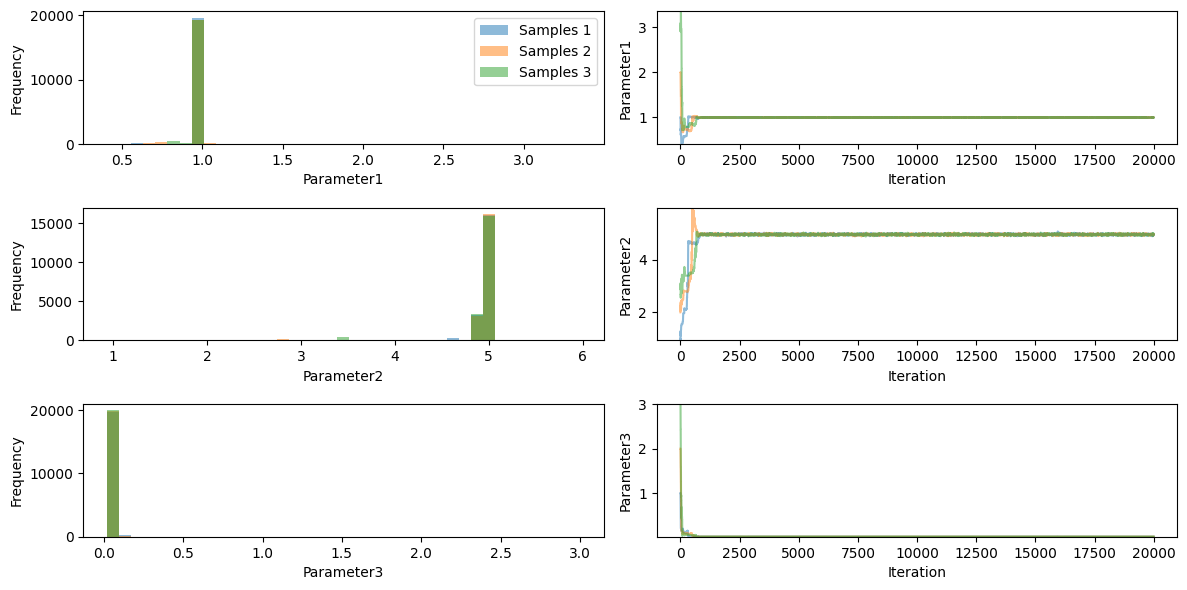

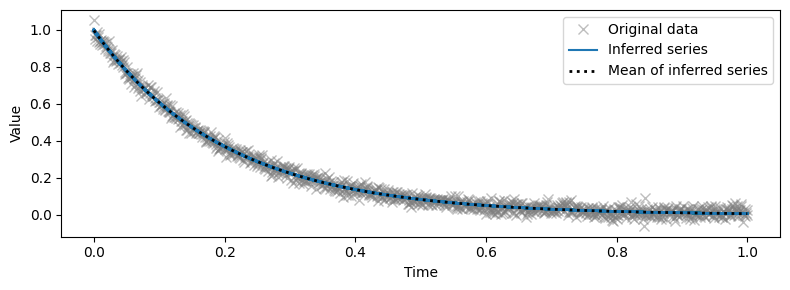

height0 estimated value: 0.9911743293817222 +/- 0.14730877526202152
decay estimated value: 4.908229467942528 +/- 0.6640221422479607
noise std estimated value: 0.02460725534750735 +/- 0.11701565083361387


In [26]:
import pints.plot
pints.plot.trace(samples)
plt.show()
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()
param_names = ['height0', 'decay', 'noise std']
for n in range(log_likelihood.n_parameters()):
    print(f'{param_names[n]} estimated value: {pints.MCMCSummary(samples).mean()[n]} +/- {2*pints.MCMCSummary(samples).std()[n]}')